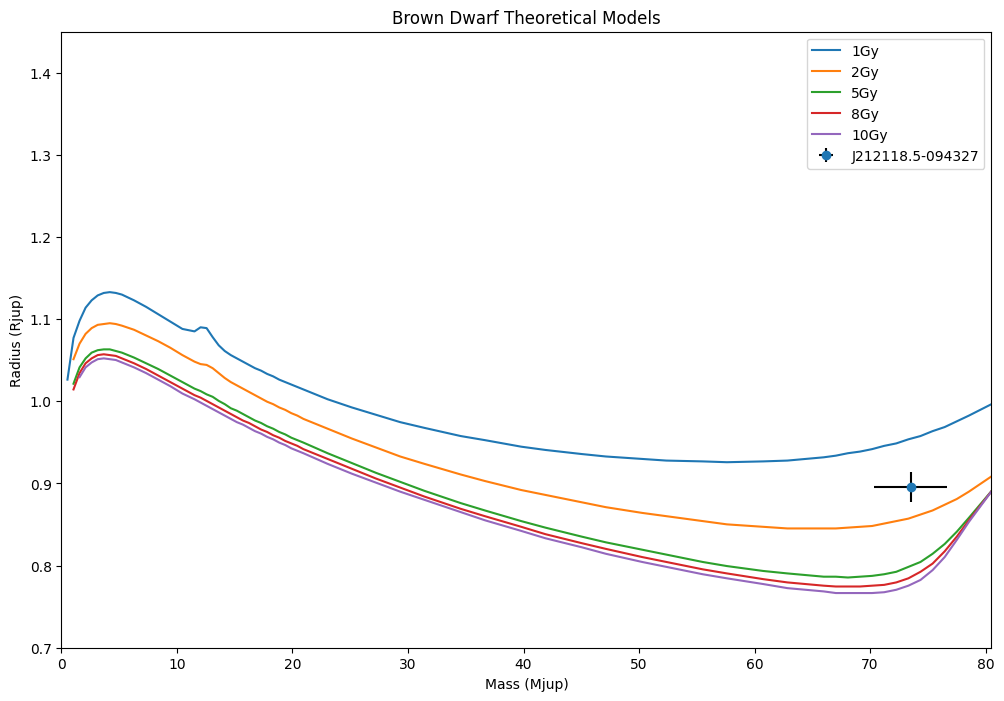

In [1]:
import numpy as np
import matplotlib.pyplot as plt

bobcat_files = [
    'bobcat_1Gy',
    'bobcat_2Gy',
    'bobcat_5Gy',
    'bobcat_8Gy',
    'bobcat_10Gy'
]

fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']


for i, filepath in enumerate(bobcat_files):

    data = np.loadtxt(filepath, skiprows=1)

    x_data = data[:, 1]*1047.35
    y_data = data[:, 5]*9.95551

    label_name = filepath.replace('bobcat_', '').replace('.dat', '')

    ax.plot(x_data, y_data, linestyle='-', color=colors[i], label=label_name)
    
mass = 0.0701950444467817 *1047.35
radius = 0.0899836309431484 *9.95551
lower_error_mass = 0.003038104468881489*1047.35
upper_error_mass = 0.0029794653579508085*1047.35
lower_error_radius = 0.0018344832696350066*9.95551
upper_error_radius = 0.0018428189739588957*9.95551
asymmetric_error_mass = [[lower_error_mass], [upper_error_mass]]      # shape (2, 1)
asymmetric_error_radius = [[lower_error_radius], [upper_error_radius]]  # shape (2, 1)

ax.errorbar(mass, radius, xerr = asymmetric_error_mass, yerr=asymmetric_error_radius, fmt='o', ecolor = 'black', label = 'J212118.5-094327')

      
ax.set_ylim(0.7, 1.45)
ax.set_xlim(0, 80.5)
ax.set_xlabel("Mass (Mjup)")
ax.set_ylabel("Radius (Rjup)")
ax.set_title("Brown Dwarf Theoretical Models")
ax.legend()
fig.savefig('BD.png')  

plt.show()


Observed Brown Dwarf Properties:
  - Mass:   73.52 M_jup
  - Radius: 0.896 R_jup
------------------------------
Interpolated Age: 1.68 +0.15 -0.18 Gy


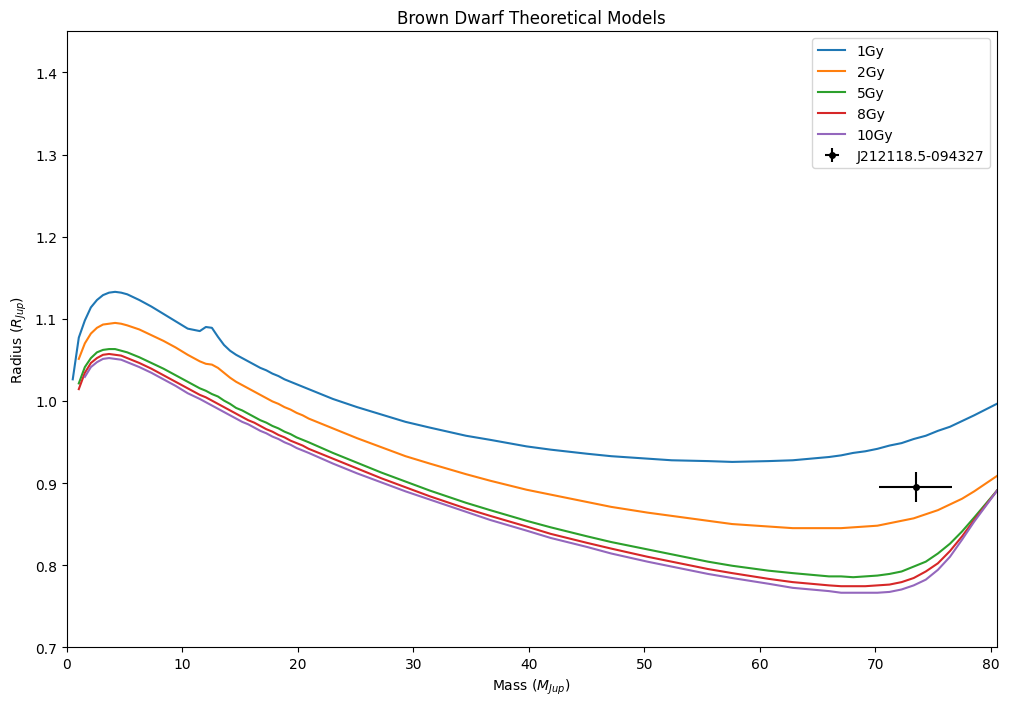

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

bobcat_files = [
    'bobcat_1Gy',
    'bobcat_2Gy',
    'bobcat_5Gy',
    'bobcat_8Gy',
    'bobcat_10Gy'
]
model_ages_gy = [1.0, 2.0, 5.0, 8.0, 10.0] # Ages of the models in Giga-years

all_masses = []
all_ages = []
all_radii = []

fig, ax = plt.subplots(figsize=(12, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i, filepath in enumerate(bobcat_files):
    data = np.loadtxt(filepath, skiprows=1)

    mass_data = data[:, 1] * 1047.35
    radius_data = data[:, 5] * 9.95551
    
    all_masses.extend(mass_data)
    all_radii.extend(radius_data)
    # Create an age array that corresponds to each data point
    all_ages.extend(np.full_like(mass_data, model_ages_gy[i]))

    label_name = filepath.replace('bobcat_', '')
    ax.plot(mass_data, radius_data, linestyle='-', color=colors[i], label=label_name)

obs_mass = 0.0701950444467817 *1047.35
obs_radius = 0.0899836309431484 *9.95551
lower_error_mass = 0.003038104468881489*1047.35
upper_error_mass = 0.0029794653579508085*1047.35
lower_error_radius = 0.0018344832696350066*9.95551
upper_error_radius = 0.0018428189739588957*9.95551
asymmetric_error_mass = [[lower_error_mass], [upper_error_mass]]
asymmetric_error_radius = [[lower_error_radius], [upper_error_radius]]

# Create the 2D interpolator: Age = f(Mass, Radius)
# 'points' are the (Mass, Radius) coordinates from all models
points_2d = np.column_stack((all_masses, all_radii))
# 'values' is the Age at each of those (Mass, Radius) points
values_age = np.array(all_ages)

age_interpolator = LinearNDInterpolator(points_2d, values_age, rescale=True)

query_point = (obs_mass, obs_radius)
higher_age_point = (obs_mass, 0.0899836309431484 * 9.95551 - 0.0018344832696350066 * 9.95551)
lower_age_point = (obs_mass, 0.0899836309431484 * 9.9555 + 0.0018428189739588957 * 9.95551)

final_age = age_interpolator(query_point)
higher_age = age_interpolator(higher_age_point)
lower_age = age_interpolator(lower_age_point)

print(f"Observed Brown Dwarf Properties:")
print(f"  - Mass:   {obs_mass:.2f} M_jup")
print(f"  - Radius: {obs_radius:.3f} R_jup")
print("-" * 30)
print(f"Interpolated Age: {final_age:.2f} +{higher_age-final_age:.2f} -{final_age-lower_age:.2f} Gy")


ax.errorbar(obs_mass, obs_radius, xerr=asymmetric_error_mass, yerr=asymmetric_error_radius, fmt='.', markersize=8, ecolor='black', color='black', label='J212118.5-094327', zorder=10)

ax.set_ylim(0.7, 1.45)
ax.set_xlim(0, 80.5)
ax.set_xlabel("Mass ($M_{Jup}$)")
ax.set_ylabel("Radius ($R_{Jup}$)")
ax.set_title("Brown Dwarf Theoretical Models")
ax.legend()
fig.savefig('BD_Interpolated_Direct.png')
plt.show()


In [1]:
#Section 1: to find the airmass and instrumental magnitudes of comparison star ---to find k
import numpy as np
import astropy.units as u
from astropy import time, coordinates as coord, units as u
from astropy.coordinates import EarthLocation, SkyCoord, AltAz
import hipercam as hcam

lat = 28.7567 * u.deg
lon = -17.8919 * u.deg  # Longitude is West, so it's negative
height = 2300 * u.m
gtc_location = EarthLocation(lat=lat, lon=lon, height=height)

hlogcs = hcam.hlog.Hlog.rascii('cs.log')

all_airmass = []
all_insmag = []
all_times = []

for ccd_id in range(1, 6):
    cs_frames = hlogcs.tseries(ccd_id, '1')

    current_ccd_airmass = []
    current_ccd_insmag = []
    current_ccd_times = []

    for frame in cs_frames:
     
        counts = np.array(frame.y)
    
        insmag = -2.5 * np.log10(counts / 2.99374) 
        current_ccd_insmag.append(insmag)

        obs_time = np.array(frame.t)
        times = time.Time(obs_time, format='mjd', scale='utc') #create a time object
        current_ccd_times.append(times)
        
        # Define comparison star coords (assume same as target)
        cs_coords = SkyCoord('21:21:17.0', '-09:42:49', unit=(u.hourangle, u.deg), frame='icrs')
        altaz_frame = AltAz(obstime=times, location=gtc_location)

        cs_in_altaz = cs_coords.transform_to(altaz_frame)
        
        # Calculate and store airmass
        airmass = float(cs_in_altaz.secz)
        current_ccd_airmass.append(airmass)

    current_ccd_airmass_array = np.array(current_ccd_airmass)
    current_ccd_times_array = np.array(current_ccd_times)
    current_ccd_insmag_array = np.array(current_ccd_insmag)
    all_airmass.append(current_ccd_airmass_array)
    all_insmag.append(current_ccd_insmag_array)
    all_times.append(current_ccd_times_array)



/usr/local/python-3.11.4/lib/python3.11/site-packages/trm/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


CCD 1: k = 0.4466+/-0.0233, m_0 = -13.017+/-0.032
0.6815288139072826 2.4527694877905272e-59


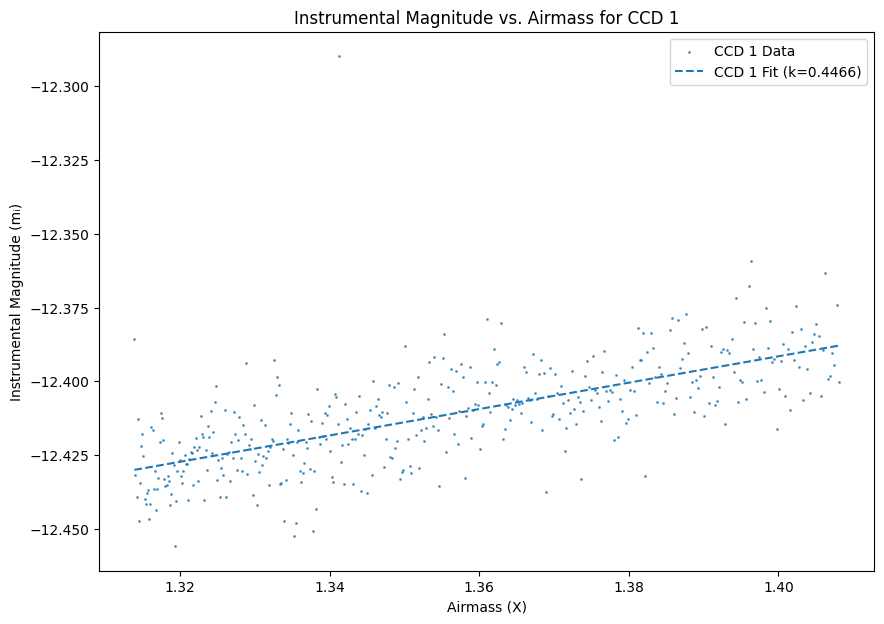

CCD 2: k = 0.1399+/-0.0243, m_0 = -11.279+/-0.033
0.19383267811160884 1.219747735188406e-08


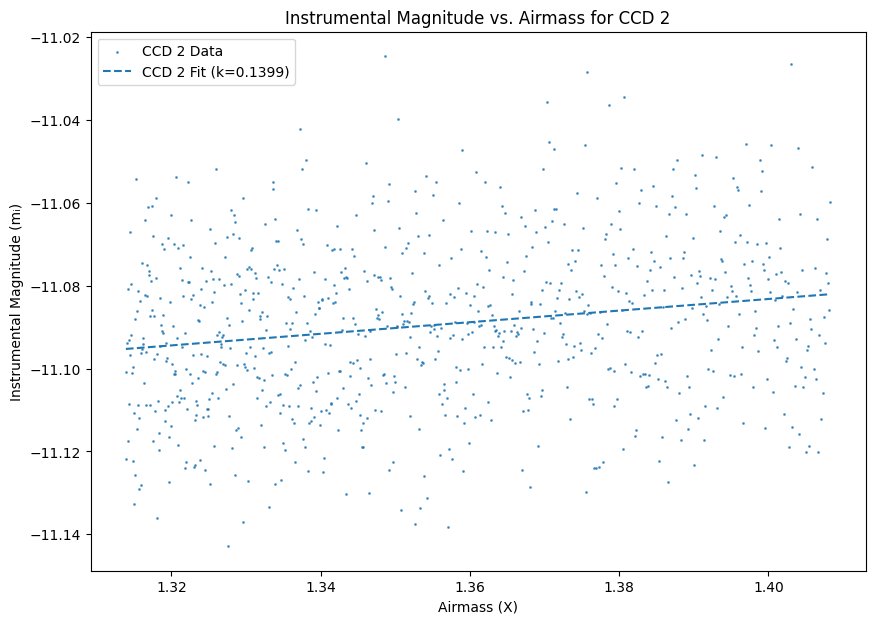

CCD 3: k = 0.1198+/-0.0205, m_0 = -11.311+/-0.028
0.19722186083872317 6.689514806026719e-09


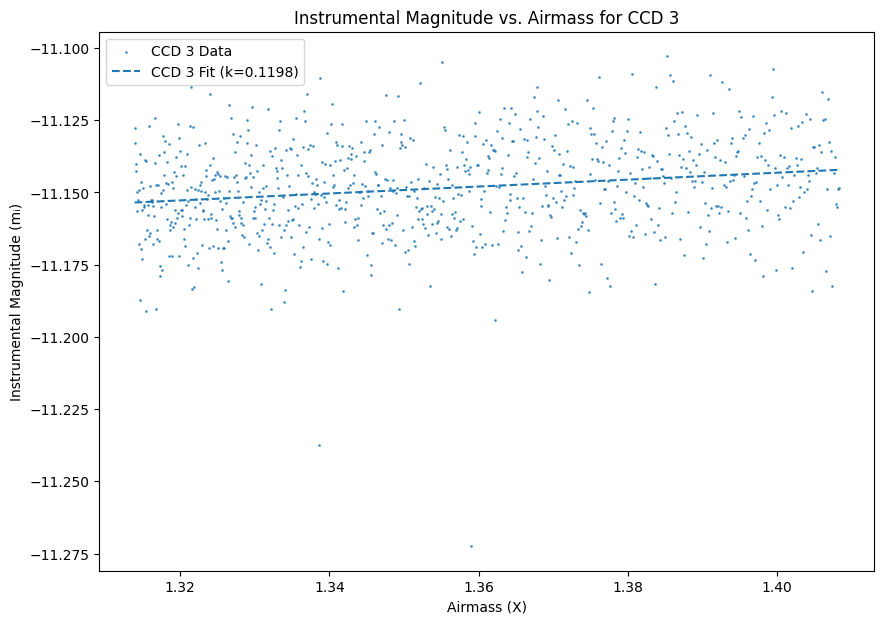

CCD 4: k = -0.0720+/-0.0374, m_0 = -11.728+/-0.051
-0.09314717906384443 0.05501012884073716


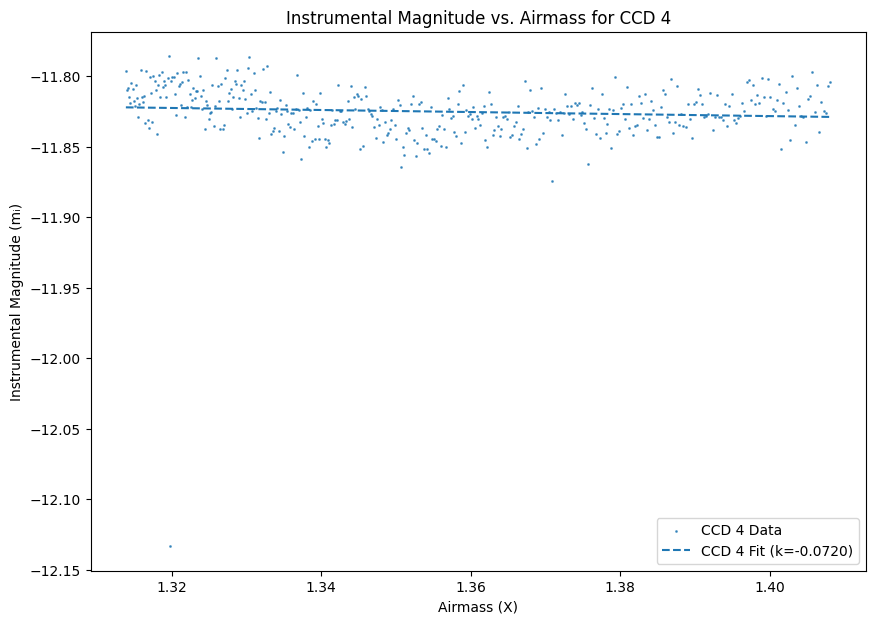

CCD 5: k = -0.0627+/-0.0306, m_0 = -11.457+/-0.041
-0.09920124097793491 0.040942946223063915


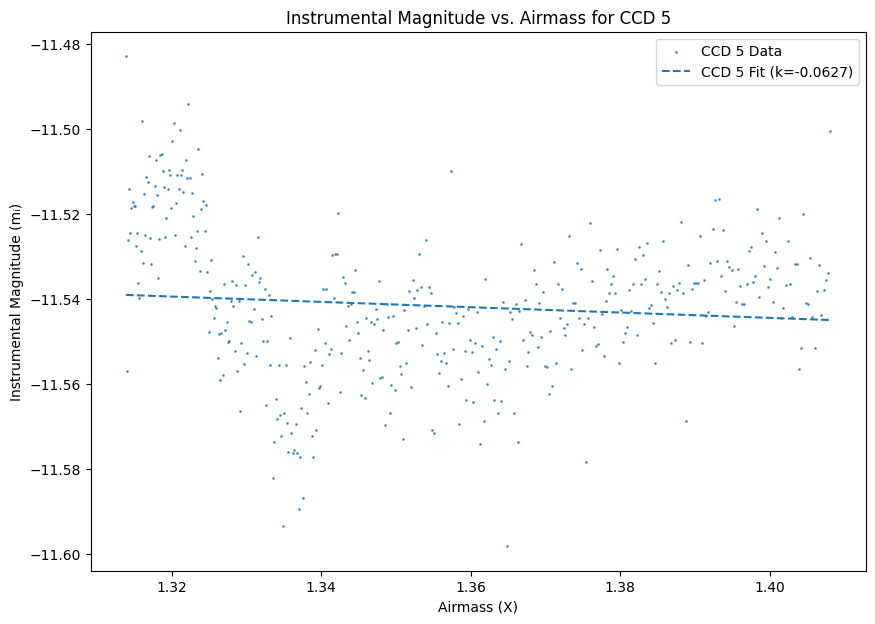

In [2]:
#Section 2: to perform linregress to find k and calibrated magnitude of the comparison star
from scipy.stats import linregress
import matplotlib.pyplot as plt
k_values = []
kerr = []

for i in range(5):
    plt.figure(figsize=(10, 7))
    x_data = all_airmass[i]
    y_data = all_insmag[i]

    result = linregress(x_data, y_data)
    k = result.slope
    m0 = result.intercept
    kerrval = result.stderr
    m0err = result.intercept_stderr
    k_values.append(k)
    kerr.append(kerrval)
    
    print(f"CCD {i+1}: k = {k:.4f}+/-{kerrval:.4f}, m_0 = {m0:.3f}+/-{m0err:.3f}")
    print(result.rvalue, result.pvalue)

    plt.scatter(x_data, y_data, label=f'CCD {i+1} Data', alpha=0.7, s=1)

    plt.plot(x_data, m0 + k * x_data, linestyle='--', label=f'CCD {i+1} Fit (k={k:.4f})')


#plt.gca().invert_yaxis() # Invert y-axis for magnitudes
    plt.title(f'Instrumental Magnitude vs. Airmass for CCD {i+1}')
    plt.xlabel('Airmass (X)')
    plt.ylabel('Instrumental Magnitude (mᵢ)')
    plt.legend()

    plt.show() 

In [3]:
#Section 3: to find the airmass and instrumental magnitude of the standard star
import numpy as np
import astropy.units as u
from astropy import time, coordinates as coord, units as u
from astropy.coordinates import EarthLocation, SkyCoord, AltAz
import hipercam as hcam
k_values = np.array(k_values)
hlogss = hcam.hlog.Hlog.rascii('ss.log')


ss_insmag = []
ss_times = []
ss_airmass = []
for ccd_id in range(1, 6):
    ss_frames = hlogss.tseries(ccd_id, '1')
    currentss_ccd_airmass = []
    currentss_ccd_insmag = []
    currentss_ccd_times = []

    for frame in ss_frames:
     
        sscounts = np.array(frame.y)
    
        ssinsmag = -2.5 * np.log10(sscounts / 4.86897) 
        currentss_ccd_insmag.append(ssinsmag)
        
        ssobs_time = np.array(frame.t)
        sstimes = time.Time(ssobs_time, format='mjd', scale='utc')
        currentss_ccd_times.append(sstimes)
        
        ss_coords = SkyCoord('16:28:25.0', '+36:46:15', unit=(u.hourangle, u.deg), frame='icrs')
        
        ssaltaz_frame = AltAz(obstime=sstimes, location=gtc_location)

        ss_in_altaz = ss_coords.transform_to(ssaltaz_frame)
        
        # Calculate and store airmass
        ssairmass = float(ss_in_altaz.secz)
        currentss_ccd_airmass.append(ssairmass)

    currentss_ccd_airmass_array = np.array(currentss_ccd_airmass)
    currentss_ccd_times_array = np.array(currentss_ccd_times)
    currentss_ccd_insmag_array = np.array(currentss_ccd_insmag)
    ss_airmass.append(currentss_ccd_airmass_array)
    ss_insmag.append(currentss_ccd_insmag_array)
    ss_times.append(currentss_ccd_times_array)        


CCD 1: k = 0.4466 (fixed), Monte Carlo m_0 = 27.700 ± 0.025


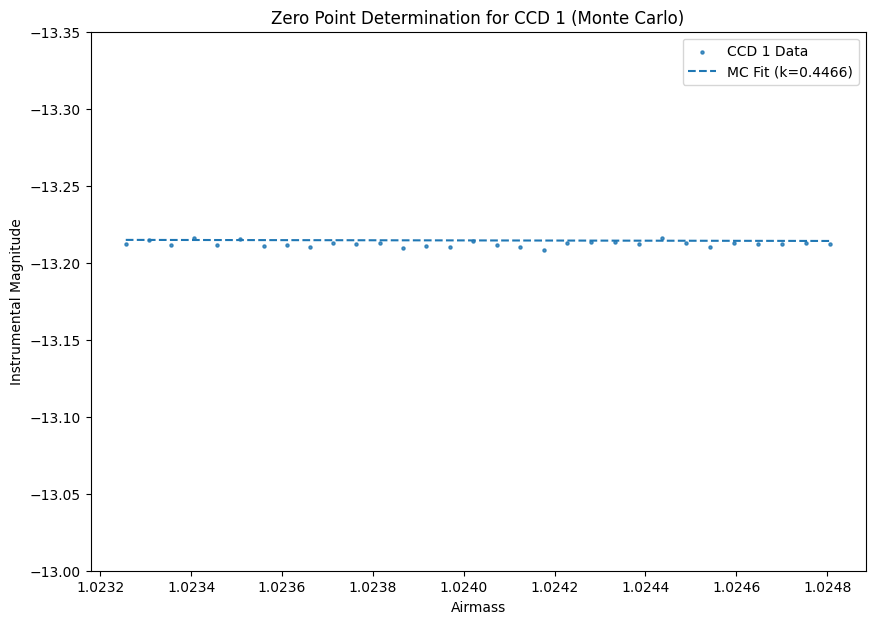

CCD 2: k = 0.1399 (fixed), Monte Carlo m_0 = 28.901 ± 0.025


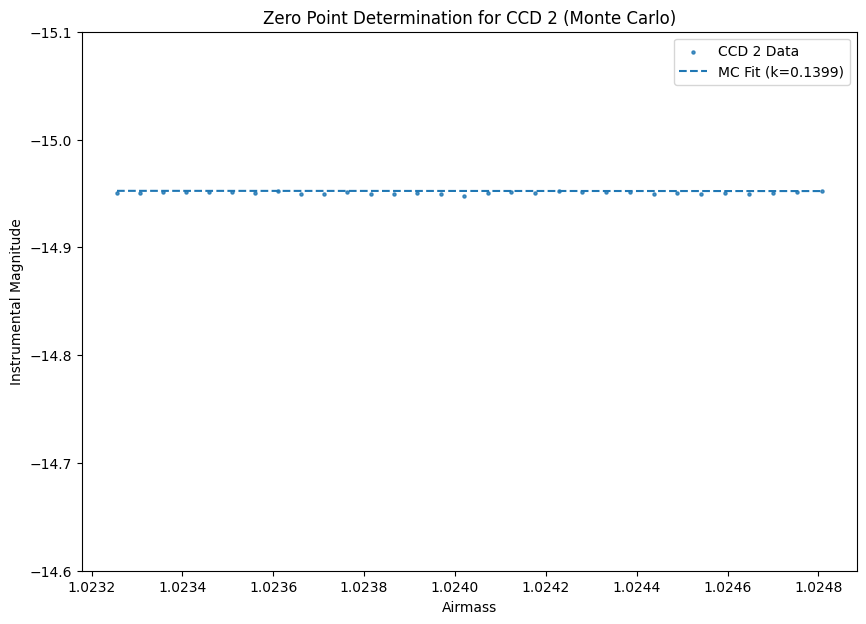

CCD 3: k = 0.1198 (fixed), Monte Carlo m_0 = 28.543 ± 0.022


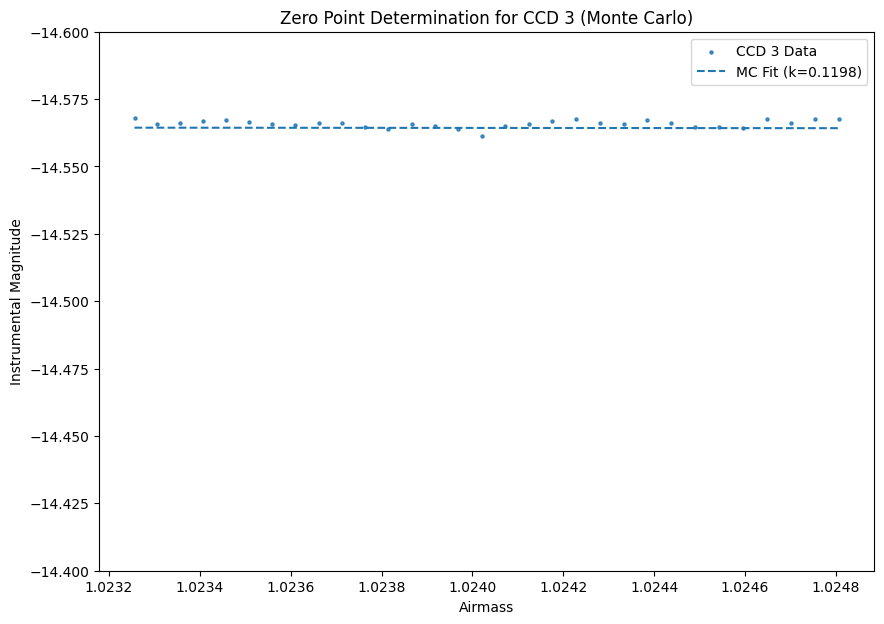

CCD 4: k = -0.0720 (fixed), Monte Carlo m_0 = 28.010 ± 0.039


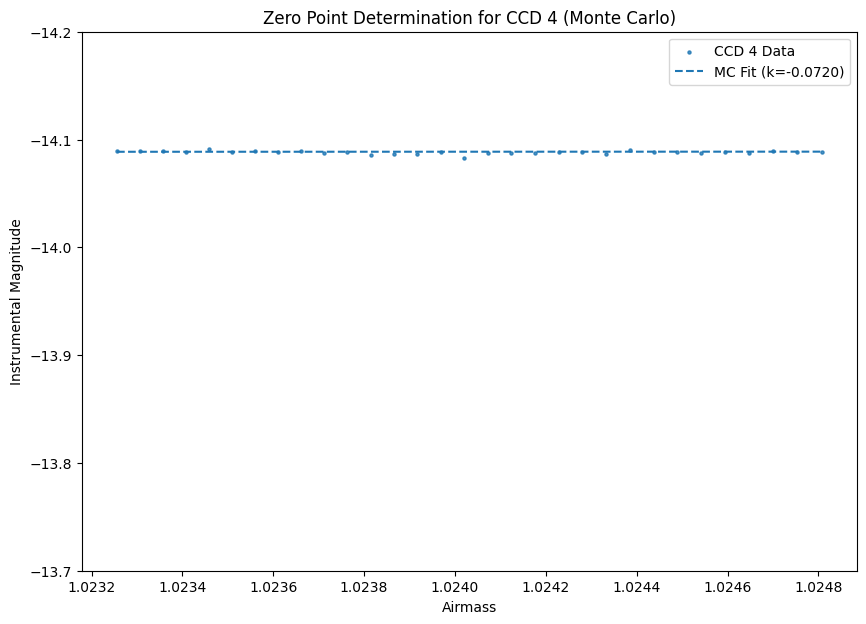

CCD 5: k = -0.0627 (fixed), Monte Carlo m_0 = 27.692 ± 0.032


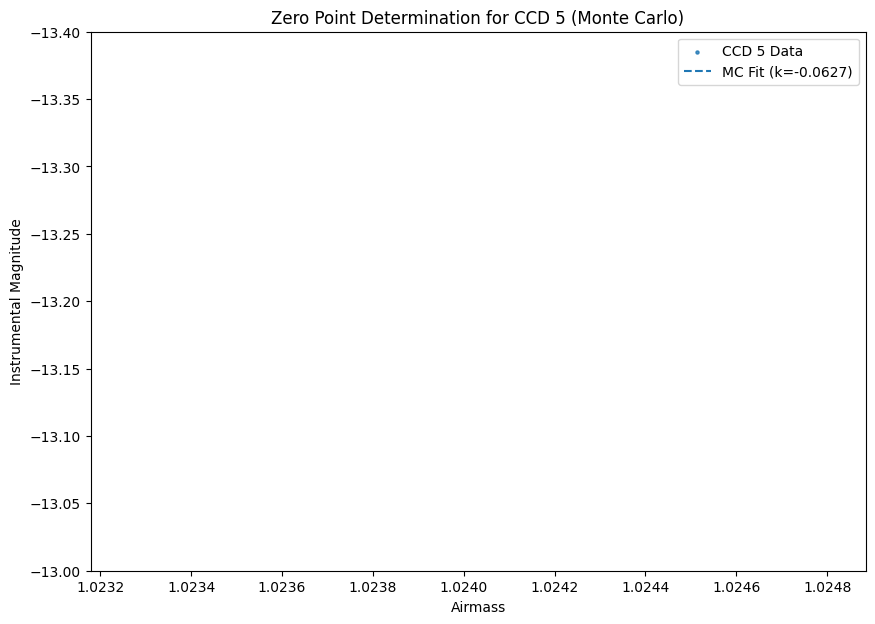


--- Final Zero Points and Errors (All CCDs) ---
CCD 1: m_0 = 27.700 ± 0.025
CCD 2: m_0 = 28.901 ± 0.025
CCD 3: m_0 = 28.543 ± 0.022
CCD 4: m_0 = 28.010 ± 0.039
CCD 5: m_0 = 27.692 ± 0.032


In [4]:
#Section 4: perform curve fit, fix k values, to find the intercept and find mzp.
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

SScalibratedmags = [14.028, 13.805, 13.856, 13.995, 14.168]
N_MC_ITERATIONS = 200

mzp_all_ccds = []
mzp_err_all_ccds = []

# Define different y-limits for each CCD
y_limits = [
    (-13.35, -13.0), # For CCD 1
    (-15.1, -14.6), # For CCD 2 (adjusted order for typical Y-axis)
    (-14.6, -14.4), # For CCD 3
    (-14.2, -13.7), # For CCD 4
    (-13.4, -13.0)  # For CCD 5
]


def run_monte_carlo_for_ccd(x_data, y_data, k_fixed, k_error, SS_cal_mag, num_iterations):
    """
    Performs Monte Carlo simulation for a single CCD to determine zero point and its error.

    Args:
        x_data (np.array): Airmass data for the CCD.
        y_data (np.array): Instrumental magnitude data for the CCD.
        k_fixed (float): The central k value for the CCD.
        k_error (float): The error (standard deviation) on the k value.
        SS_cal_mag (float): The calibrated magnitude for the CCD's standard star.
        num_iterations (int): Number of Monte Carlo samples.

    Returns:
        tuple: (mean_mzp, std_mzp), the mean and standard deviation of the zero points.
    """
    mzp_samples = []

    for i in range(num_iterations):
        k_sample = np.random.normal(loc=k_fixed, scale=k_error)

        def fixed_slope_line_mc(x, intercept):
            return k_sample * x + intercept
            
        popt, pcov = curve_fit(fixed_slope_line_mc, x_data, y_data)
        intercept_sample = popt[0]

        mzp_sample = SS_cal_mag - intercept_sample
        mzp_samples.append(mzp_sample)

    mean_mzp = np.mean(mzp_samples)
    std_mzp = np.std(mzp_samples) 

    return mean_mzp, std_mzp


for i in range(len(SScalibratedmags)):
    plt.figure(figsize=(10, 7))

    x_data_ccd = np.array(ss_airmass[i])
    y_data_ccd = np.array(ss_insmag[i])
    k_ccd = k_values[i]
    k_error_ccd = kerr[i] 
    SS_cal_mag_ccd = SScalibratedmags[i]

    # Perform the Monte Carlo simulation
    mzp_val, mzp_err = run_monte_carlo_for_ccd(
        x_data_ccd, y_data_ccd, k_ccd, k_error_ccd, SS_cal_mag_ccd, N_MC_ITERATIONS
    )

    mzp_all_ccds.append(mzp_val)
    mzp_err_all_ccds.append(mzp_err)

    print(f"CCD {i+1}: k = {k_ccd:.4f} (fixed), Monte Carlo m_0 = {mzp_val:.3f} ± {mzp_err:.3f}")

    # For plotting, use the original fixed k and the mean intercept from the MC simulation
    def fixed_slope_line_plot(x, intercept):
        return k_ccd * x + intercept

    # To get the intercept corresponding to mzp_val, you'd calculate:
    intercept_for_plot = SS_cal_mag_ccd - mzp_val

    plt.scatter(x_data_ccd, y_data_ccd, label=f'CCD {i+1} Data', alpha=0.8, s=5)
    plt.plot(x_data_ccd, fixed_slope_line_plot(x_data_ccd, intercept_for_plot), linestyle='--',
             label=f'MC Fit (k={k_ccd:.4f})') 


    plt.xlabel("Airmass")
    plt.ylabel("Instrumental Magnitude")
    plt.ylim(y_limits[i][1], y_limits[i][0]) 
    plt.legend()
    plt.title(f"Zero Point Determination for CCD {i+1} (Monte Carlo)")
    plt.savefig(f"zeropoint_mc_ccd_{i+1}.png")
    plt.show()

print("\n--- Final Zero Points and Errors (All CCDs) ---")
for i, (zp, zperr) in enumerate(zip(mzp_all_ccds, mzp_err_all_ccds)):
    print(f"CCD {i+1}: m_0 = {zp:.3f} ± {zperr:.3f}")

In [5]:
import numpy as np
relativefluxerror = np.array(mzp_err_all_ccds) * (np.log(10) / 2.5)
print(relativefluxerror)

[0.02294464 0.02301242 0.01998383 0.03563459 0.0297118 ]


In [6]:
import numpy as np
import hipercam as hcam


mzp_website_ccds = [28.17,29.25,28.76,28.43,27.95]
calibmag_list_1 = []
calibmag_list_2 = []
calibmag_list_3 = []
calibmag_list_4 = []
calibmag_list_5 = []
k_values_reshaped = k_values[:, np.newaxis]
print(k_values_reshaped)
for k, ccd_id in enumerate(range(1, 6)):
    ape_number = '1' 
    cs_frames = hlogcs.tseries(ccd_id, '1')
    ccd_zero_point = mzp_all_ccds[ccd_id-1]
    for frame in cs_frames:
        counts = np.array(frame.y)
        
        insmag = -2.5 * np.log10(counts / (frame.te*86400))
        calibmag = insmag + ccd_zero_point - k_values_reshaped[k]*all_airmass[k] 
        if ccd_id == 1:
            calibmag_list_1.append(calibmag)
        elif ccd_id == 2:
            calibmag_list_2.append(calibmag)
        elif ccd_id == 3:
            calibmag_list_3.append(calibmag)
        elif ccd_id == 4:
            calibmag_list_4.append(calibmag)
        elif ccd_id == 5:
            calibmag_list_5.append(calibmag)
print(np.mean(calibmag_list_1))
print(k_values_reshaped[0]*np.mean(all_airmass[0]))

[[ 0.4466367 ]
 [ 0.13988955]
 [ 0.11983806]
 [-0.07202651]
 [-0.06272073]]
15.436939852758098
[0.60544882]


In [7]:
flux_1 = 10**(-0.4 * (np.average(calibmag_list_1) - 8.9)) 
flux_2 = 10**(-0.4 * (np.average(calibmag_list_2) - 8.9)) 
flux_3 = 10**(-0.4 * (np.average(calibmag_list_3) - 8.9)) 
flux_4 = 10**(-0.4 * (np.average(calibmag_list_4) - 8.9)) 
flux_5 = 10**(-0.4 * (np.average(calibmag_list_5) - 8.9)) 
all_flux_lists = [flux_1, flux_2, flux_3, flux_4, flux_5]
print(np.average(calibmag_list_1), flux_1)

15.436939852758098 0.002427862341840975


0.038262375
9.289577990221232e-05
0.35569242
0.00011547601141804753
0.19314604
8.975368725043724e-05
0.121392235
6.755584042872768e-05
0.08638961
5.019787990040198e-05


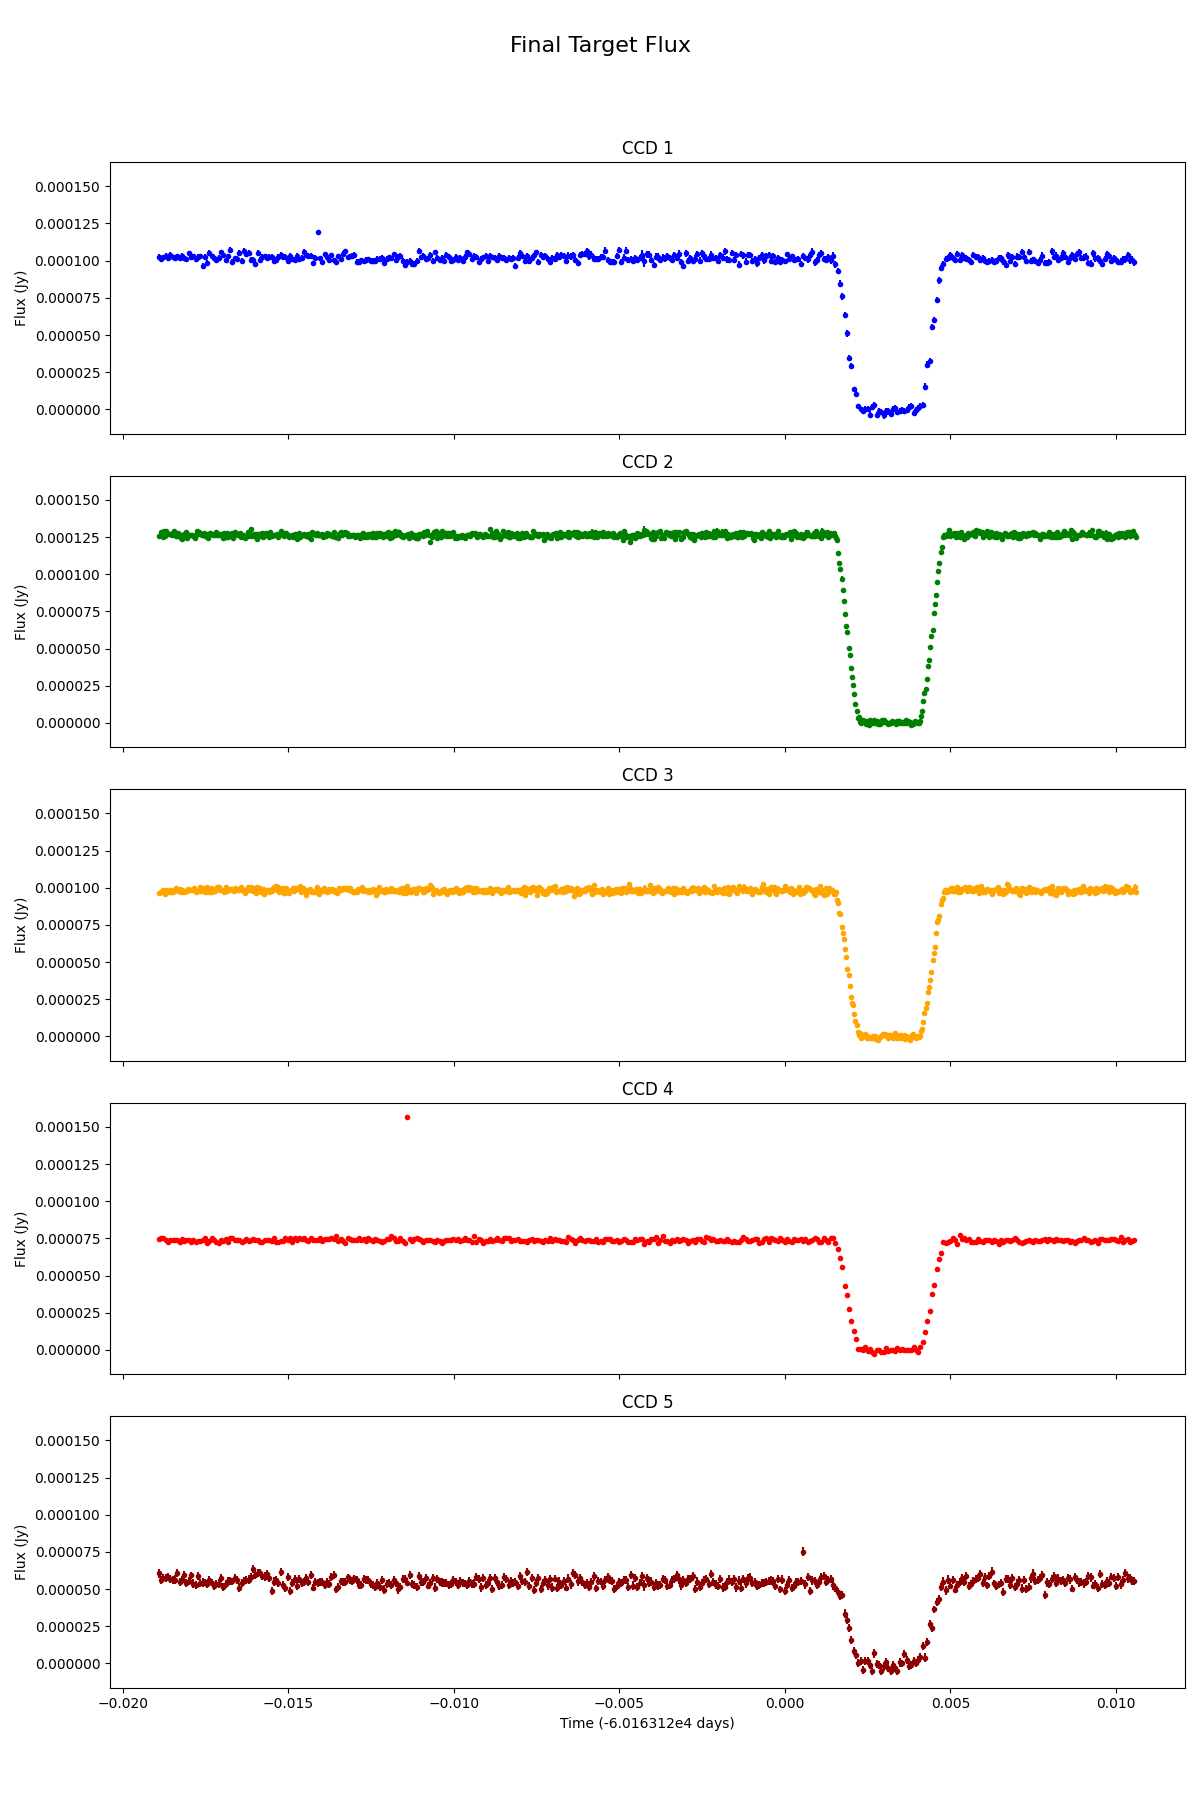

In [8]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget


hlog = hcam.hlog.Hlog.rascii('20.log')

ccd_colors = {'1': 'blue', '2': 'green', '3': 'orange', '4': 'red', '5': 'darkred'}
targetfluxlistnew = []
targeterrorlistnew = []
targetexposurelistnew = []
fig, axes = plt.subplots(5, 1, figsize=(12, 18), sharex=True, sharey=True)
fig.suptitle("Final Target Flux", fontsize=16)

for i in range(5):
    ccd = str(i + 1)
    ax = axes[i]

    targ = hlog.tseries(ccd, '1')
    exposuretime = targ.te
    targetexposurelistnew.append(exposuretime)
    comp = hlog.tseries(ccd, '2')

    ratio = targ / comp
    
    target_flux = ratio.y * all_flux_lists[i]
    print(np.mean(ratio.y))
    print(np.mean(target_flux))
    target_error = all_flux_lists[i] * ratio.ye

    targetfluxlistnew.append(target_flux)
    targeterrorlistnew.append(target_error)
    time_data = targ.t
    
    ax.errorbar(time_data-6.016312e4, target_flux, yerr=target_error, marker='.', linestyle='none', color=ccd_colors[ccd])
    
    ax.set_title(f"CCD {i+1}")
    ax.set_ylabel("Flux (Jy)")
    if i == 4:
        ax.set_xlabel('Time (-6.016312e4 days)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import time, coordinates as coord, units as u

allbjd = []

for ccd_id in range(1, 6):
    ltt_barylist=[]
    bjdlistperccd=[]
    ape_number = '1' 
    wd_frames = hlog.tseries(ccd_id, ape_number)
    for frame in wd_frames:
     
        WD = coord.SkyCoord('21:21:17.0', '-09:42:49',
                        unit=(u.hourangle, u.deg), frame='icrs')
        obs_time = np.array(frame.t)
        times = time.Time([obs_time], format='mjd', scale='utc', location=gtc_location)
        ltt_bary = times.light_travel_time(WD)
        ltt_barylist.append(ltt_bary)
        time_barycentre = times.tdb + ltt_bary.value.item() #corrected times BMJD
        bjdlistperccd.append(time_barycentre.value)
    allbjd.append(np.ravel(bjdlistperccd))
    

In [10]:
import numpy as np

def calculate_oot_flux(time_data, flux_data):
    oot_mask = (time_data < 0.0280+6.01631e4) | (time_data > 0.0315+6.01631e4) #after corrected for bjd
    mean_flux = np.mean(flux_data[oot_mask])
    return mean_flux

def convert_flux_to_mag(flux):

    calibmag = -2.5 * np.log10(flux) + 8.9
    return calibmag

for i in range(5):
    time_data = allbjd[i]  # Use BJD time from allbjdlist
    flux_data = targetfluxlistnew[i]

    mean_oot_flux = calculate_oot_flux(time_data, flux_data)
    calibrated_mag = convert_flux_to_mag(mean_oot_flux)
    
    print(f"  -> Mean Out-of-Eclipse Flux: {mean_oot_flux:.8f} Jy")
    print(f"  -> Calibrated Magnitude: {calibrated_mag:.3f}")



  -> Mean Out-of-Eclipse Flux: 0.00010183 Jy
  -> Calibrated Magnitude: 18.880
  -> Mean Out-of-Eclipse Flux: 0.00012646 Jy
  -> Calibrated Magnitude: 18.645
  -> Mean Out-of-Eclipse Flux: 0.00009833 Jy
  -> Calibrated Magnitude: 18.918
  -> Mean Out-of-Eclipse Flux: 0.00007404 Jy
  -> Calibrated Magnitude: 19.226
  -> Mean Out-of-Eclipse Flux: 0.00005500 Jy
  -> Calibrated Magnitude: 19.549


--- Median Out-of-Eclipse Signal-to-Noise Ratios ---
CCD 1: 50.95
CCD 2: 95.29
CCD 3: 75.47
CCD 4: 75.74
CCD 5: 20.04


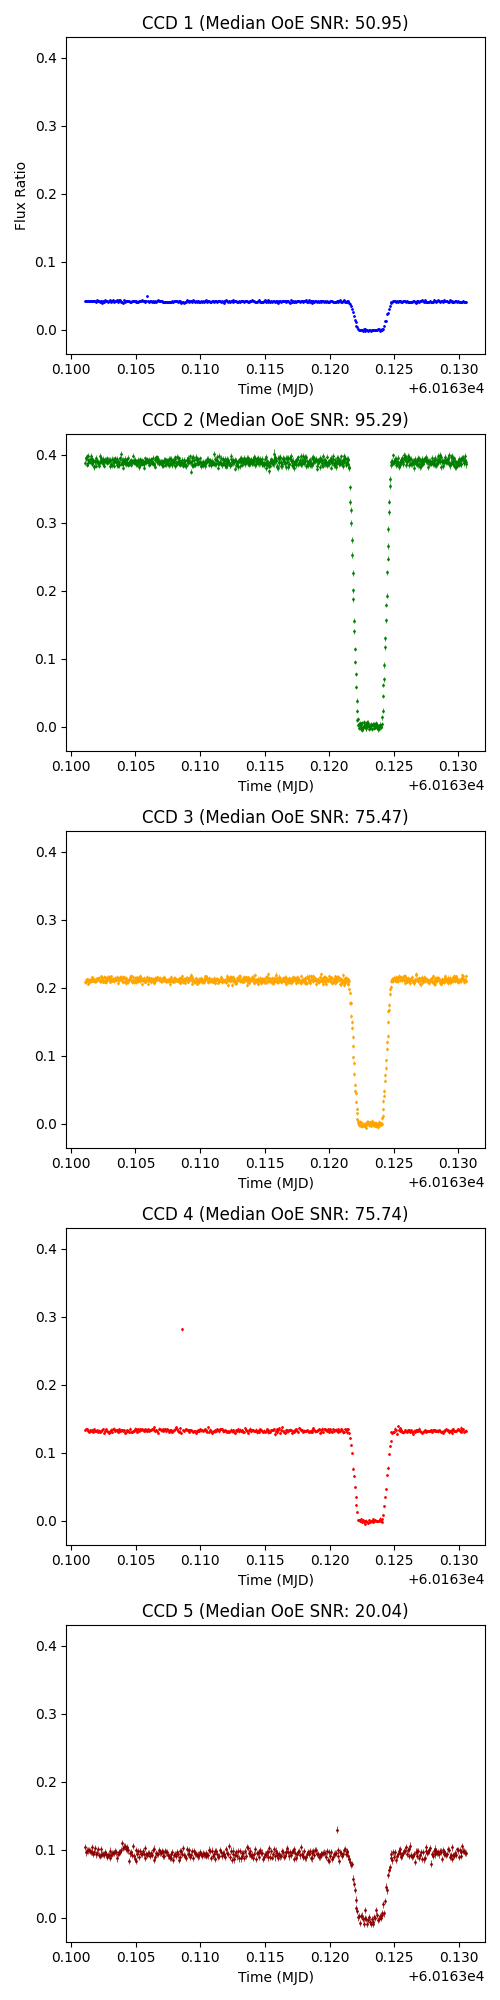

In [11]:
import matplotlib.pyplot as plt
import hipercam as hcam
import numpy as np
%matplotlib widget
hlog = hcam.hlog.Hlog.rascii('20.log')

ccd_colors = {
    '1': 'blue',
    '2': 'green',
    '3': 'orange',
    '4': 'red',
    '5': 'darkred'
}

fig, axes = plt.subplots(5, 1, figsize=(5, 20), sharey=True)

print("--- Median Out-of-Eclipse Signal-to-Noise Ratios ---")

for i in range(5):
    ccd = str(i + 1)
    color = ccd_colors[ccd]

    targ = hlog.tseries(ccd, '1')
    comp = hlog.tseries(ccd, '2')

    ratio = targ / comp

    # --- SNR CALCULATION ---
    snr_all_points = ratio.y / ratio.ye

    # Create a boolean mask to select points outside the eclipse time range.
    out_of_eclipse_mask = (ratio.t < 0.0015+6.016312e4) | (ratio.t > 0.00455+6.016312e4)

    # Calculate the MEDIAN SNR using only the out-of-eclipse data.
    # np.nanmedian to ignore any NaN values within the selected data.
    median_snr = np.nanmedian(snr_all_points[out_of_eclipse_mask])

    print(f'CCD {ccd}: {median_snr:.2f}')
    # --- END MODIFIED SNR CALCULATION ---

    ax = axes[i]
    ratio.mplot(ax, fmt='.', color=color, markersize=2, linewidth=0.5)
    ax.set_title(f'CCD {ccd} (Median OoE SNR: {median_snr:.2f})')
    ax.set_xlabel('Time (MJD)') 
    if i == 0:
        ax.set_ylabel('Flux Ratio')

plt.tight_layout()
plt.show()
plt.savefig("lightcurve.png")

In [12]:
import numpy as np

for i in range(5):
    # Column 1: BMJD
    bjd_col = allbjd[i]

    # Column 2: Exposure Time 
    exp_time_col = targetexposurelistnew[i]

    # Column 3: Flux in Jansky 
    flux_jy_col = targetfluxlistnew[i] 

    # Column 4: Flux Error in Jansky
    flux_err_jy_col = targeterrorlistnew[i] 

    # Column 5: Weight Factors (remains as integer 1s)
    weight_col = np.ones_like(bjd_col, dtype=int)
    
    # Column 6: Subdivisions
    subdivision_col = np.ones_like(bjd_col, dtype=int)

    base_mjd = 6.01631e4
    range1 = (bjd_col >= 0.0275 + base_mjd) & (bjd_col <= 0.0293 + base_mjd)
    range2 = (bjd_col >= 0.0302 + base_mjd) & (bjd_col <= 0.032 + base_mjd)
#| means or
    five_range = range1 | range2

    # Use the mask to update the subdivision to 5 only for those specific times.
    subdivision_col[five_range] = 5
  
    output_data = np.column_stack([
        bjd_col,
        exp_time_col,
        flux_jy_col,
        flux_err_jy_col,
        weight_col,
        subdivision_col
    ])

    filename = f"ccd_newlightcurve_{i+1}.txt"

    np.savetxt(filename, output_data, fmt=['%.8f', '%.8f', '%.8f', '%.8f', '%d', '%d'], delimiter=' ')

In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt

# Assuming 'hcam' and 'all_flux_lists' are defined elsewhere in your code
# from some_module import hcam, all_flux_lists

#%matplotlib widget

# This is a placeholder for your actual data
# all_flux_lists = [flux_1, flux_2, flux_3, flux_4, flux_5]

# hlog = hcam.hlog.Hlog.rascii('19.log')

#ccd_colors = {'1': 'blue', '2': 'green', '3': 'orange', '4': 'red', '5': 'darkred'}
#highlight_color = 'magenta'  # Choose a color for the highlighted points

#targetfluxlist = []
#targeterrorlist = []
#targetexposurelist = []

#fig.suptitle("Final Target Flux", fontsize=16)

#base_mjd = 6.01631e4

for i in range(5):
    ccd = str(i + 1)
    ax = axes[i]

    targ = hlog.tseries(ccd, '1')
    exposuretime = targ.te
    targetexposurelist.append(exposuretime)
    comp = hlog.tseries(ccd, '2')

    current_flux_list = all_flux_lists[i]

    ratio = targ / comp

    target_flux = ratio.y * current_flux_list * 1e3
    target_error = current_flux_list * 1e3 * ratio.ye

    targetfluxlist.append(target_flux)
    targeterrorlist.append(target_error)
    time_data = allbjd[i]

    # Define the time ranges for highlighting
    bjd_col = time_data  # Assuming time_data corresponds to bjd_col
    range1 = (bjd_col >= 0.0275 + base_mjd) & (bjd_col <= 0.0293 + base_mjd)
    range2 = (bjd_col >= 0.0302 + base_mjd) & (bjd_col <= 0.032 + base_mjd)
    highlight_mask = range1 | range2

    # Plot all points in the default color
    ax.errorbar(time_data, target_flux, yerr=target_error, marker='.', linestyle='none', color=ccd_colors[ccd], label='All Data')

    # Overlay the highlighted points in a different color
    ax.errorbar(time_data[highlight_mask], target_flux[highlight_mask], yerr=target_error[highlight_mask], marker='.', linestyle='none', color=highlight_color, label='Highlighted Range')

    ax.set_title(f"CCD {i+1}")
    ax.set_ylabel("Flux (mJy)")
    ax.legend()

# Set a common x-label
axes[-1].set_xlabel("Time (BJD)")

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()